In [1]:
import sys
sys.path.insert(0, '../')

import pandas as pd
from preprocess import Audio_Processor
from data_utils import balanced_supersample, balanced_subsample
from sklearn import metrics
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os
import numpy as np
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
import time
from collections import Counter

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
%load_ext memory_profiler
%load_ext line_profiler

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="0"

SR = 16000
blocksize = int(SR/2)
overlap = int(SR/4)

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [5]:
path_to_db='../../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/', sr=SR)
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']
mapping = {'dog': 0,'rooster': 0,'pig': 0,'cow': 0,'frog': 0,'cat': 0,'hen': 0,
            'insects': 0,'sheep': 0,'crow': 0,'rain': 1,'sea_waves': 1,'crackling_fire': 1,
            'crickets': 0,'chirping_birds': 0,'water_drops': 1,'wind': 1,'pouring_water': 1,
            'toilet_flush': 1,'thunderstorm': 1,'crying_baby': 0,'sneezing': 0,'clapping': 0,
            'breathing': 0,'coughing': 0,'footsteps': 1,'laughing': 0,'brushing_teeth': 1,
            'snoring': 0,'drinking_sipping': 1,'door_wood_knock': 1,'mouse_click': 1,
            'keyboard_typing': 1,'door_wood_creaks': 1,'can_opening': 1,'washing_machine': 1,
            'vacuum_cleaner': 1,'clock_alarm': 1,'clock_tick': 1,'glass_breaking':1,'helicopter': 1,
            'chainsaw': 1,'siren': 1,'car_horn': 1,'engine': 1,'train': 1,'church_bells': 1,
            'airplane': 1,'fireworks': 1,'hand_saw': 1,
            }
dataset['h_target'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_target'] = mapping[row['category']]

In [6]:
df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        blocksize=blocksize, 
                        overlap=overlap,
                        feature_bag=False,
                        folds=5
                       )
df.head()

,target,h_target,metadata,fold
0,0,0,mfcc_2_std mfcc_2_mean mfcc_2_noise mfcc...,1
1,14,0,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...,5
2,36,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...,3
3,36,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...,5
4,19,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...,3


In [7]:
train = ps.bag_of_features(df[df.fold != 1].reset_index())
train.head()

,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,mfcc_4_noise,mfcc_5_std,...,sflat_noise,sroll_std,sroll_mean,sroll_noise,rmse_std,rmse_mean,rmse_noise,h_target,target,fold
0,81.355627,60.950895,35.026463,48.047609,53.739915,42.014673,48.515288,36.766431,53.463175,52.233060,...,0.425719,0.243835,12.205491,13.338520,5.419358,15.416913,3.034387,0,14,5
1,82.090071,66.576588,44.457472,43.406209,51.750090,33.061378,44.813918,43.999085,45.518410,41.850523,...,-0.012500,0.257141,9.483506,12.958784,4.558367,15.372567,2.792519,0,14,5
2,84.208982,62.966970,46.823424,37.631471,47.758099,42.029236,54.039877,44.406314,43.668848,47.363946,...,0.079334,0.517184,12.201532,11.095703,4.802391,15.916300,3.168262,0,14,5
3,70.073610,82.465856,47.496273,57.899457,57.234505,36.226570,59.486281,44.904293,37.335008,41.632832,...,0.297949,0.001637,9.933414,15.130064,4.932393,18.708356,3.396824,0,14,5
4,64.759162,101.448273,69.353902,61.032527,48.199999,48.181578,57.047702,46.993057,49.225614,39.971573,...,0.186153,0.195547,15.884816,10.161794,5.320202,13.979928,3.583472,0,14,5


In [8]:
test = ps.bag_of_features(df[df.fold == 1].reset_index())
test.head()

,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,mfcc_4_noise,mfcc_5_std,...,sflat_noise,sroll_std,sroll_mean,sroll_noise,rmse_std,rmse_mean,rmse_noise,h_target,target,fold
0,52.009557,4.327045,5.696827,6.522973,3.426770,9.314700,8.897445,1.613144,3.654356,6.125930,...,-0.430331,0.430331,29.442891,33.986595,7.463287,129.495423,54.772801,0,0,1
1,88.404377,82.645071,55.548627,51.936489,32.090942,23.103625,23.082517,18.536499,16.418501,15.469806,...,0.475820,-0.102448,15.695233,20.199985,3.943083,20.152053,1.728330,0,0,1
2,86.987377,78.083572,51.433488,51.561430,33.107803,31.318922,21.869279,15.681414,22.181496,16.827397,...,0.254841,0.158864,14.345672,19.755847,3.758124,17.172734,1.683485,0,0,1
3,80.670230,68.750011,19.582458,23.847321,18.158782,20.392203,9.204180,11.268402,12.634953,12.072391,...,0.278538,0.105655,25.330133,34.365584,4.991139,27.321271,10.232799,0,0,1
4,42.506857,44.615253,47.087501,35.378869,37.428373,29.702010,28.531477,28.787457,29.820697,28.200109,...,-0.494081,-0.344873,10.879572,21.144866,5.707841,19.240847,2.952259,1,47,1


In [9]:
train_X = train.drop(['target', 'h_target', 'fold'], axis=1)
train_y = train[['h_target', 'target']]
test_X = test.drop(['target', 'h_target', 'fold'], axis=1)
test_y = test[['h_target', 'target']]

In [10]:
print(train_X.shape)
print(test_X.shape)

(27758, 129)
(6964, 129)


In [11]:
%%file hybmulder.py

import numpy as np
import inspect
from sklearn.base import BaseEstimator, ClassifierMixin
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.neighbors import KNeighborsClassifier

class Hybrid_Multilayer_KNN(BaseEstimator, ClassifierMixin):
    def __init__(self, epochs=50, batch_size=35, validation_split=0.05,
                       a_neighbors=50, a_algorithm='ball_tree',
                       i_neighbors=50, i_algorithm='ball_tree',
                       verbose=1, proc=None
                ):
        
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")

        for arg, val in values.items():
            setattr(self, arg, val)
            pass
    
    
    def fit(self, X, y):
        
        X = np.array(X)
        y = np.array(y)
        
        if self.proc:
            X = self.proc.fit_transform(X, y[:,1])
        
        dims = X.shape[1]
        t_y = y[:,0]
        a_y = y[:,1][t_y == 0]
        i_y = y[:,1][t_y == 1]
        
        """Top layer of hierarchy"""
        self.clf = KerasClassifier(build_fn=self.deep_net,
                                   feature_count=dims,
                                   epochs=self.epochs, 
                                   batch_size=self.batch_size, 
                                   validation_split=self.validation_split,
                                   verbose=self.verbose
                                  )
        self.clf.fit(X, t_y)
        
        """Animal Layer"""
        self.a_clf = KNeighborsClassifier(n_neighbors=self.a_neighbors, algorithm=self.a_algorithm)
        
        self.a_clf.fit(X[t_y == 0], a_y)
        
        """Interacting Materials Layer"""
        self.i_clf = KNeighborsClassifier(n_neighbors=self.i_neighbors, algorithm=self.i_algorithm)
        
        self.i_clf.fit(X[t_y == 1], i_y)
        
        return self
        
    def predict(self, X, y=None):
        predictions=[]
        
        if self.proc:
            X = self.proc.transform(np.array(X))
    
        for x in X:
            prob = self.clf.predict_proba(x[np.newaxis,:], verbose=0).squeeze()
            if prob[0] > 0.75:
                pred = self.a_clf.predict(x[np.newaxis,:]).squeeze()
            elif prob[1] > 0.75:
                pred = self.i_clf.predict(x[np.newaxis,:]).squeeze()
            else:
                a_pred = self.a_clf.predict(x[np.newaxis,:]).squeeze()
                i_pred = self.i_clf.predict(x[np.newaxis,:]).squeeze()
                
                a_prob = self.a_clf.predict_proba(x[np.newaxis,:]).squeeze() * prob[0]
                i_prob = self.i_clf.predict_proba(x[np.newaxis,:]).squeeze() * prob[1]
                
                if(np.max(a_prob) > np.max(i_prob)):
                    pred = a_pred
                else:
                    pred = i_pred
                    
            predictions.append(pred)
        
        return predictions
    
    def predict_proba(self, X, y=None):
        
        if self.proc:
            X = self.proc.transform(np.array(X))
        
#         print(self.a_clf.classes_)
#         print(self.i_clf.classes_)
        
        prob = self.clf.predict_proba(X, verbose=0).squeeze()
        prob_a = np.multiply(self.a_clf.predict_proba(X, verbose=0).squeeze().T,prob[:,0]).T
        prob_i = np.multiply(self.i_clf.predict_proba(X, verbose=0).squeeze().T,prob[:,1]).T

        probs = []
        
        for i in range(0, len(prob_a)):
            tmp = [None] * 50
            for counter, j in enumerate(self.a_clf.classes_):
                tmp[j] = prob_a[i][counter]
            for counter, j in enumerate(self.i_clf.classes_):
                tmp[j] = prob_i[i][counter]
            probs.append(tmp)
            
        return np.array(probs)
        
    
    def deep_net(self, feature_count):
        # Create Model
        print(feature_count)
        model = Sequential()
        model.add(Dense(feature_count, activation='tanh', input_shape=(feature_count,)))
        model.add(Dropout(0.2))
        model.add(Dense(feature_count, activation='tanh'))
        model.add(Dropout(0.2))
        model.add(Dense(int(feature_count/2), activation='tanh'))
        model.add(Dense(int(feature_count/2), activation='tanh'))
        model.add(Dropout(0.2))
        model.add(Dense(int(feature_count/2), activation='tanh'))
        model.add(Dropout(0.2))
        model.add(Dense(1, activation='softmax'))

        # Compile model
        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])


        return model

Overwriting hybmulder.py


## Training

In [12]:
%%time

from hybmulder import Hybrid_Multilayer_KNN
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.decomposition import PCA

proc = Pipeline([
    ('scaler', MinMaxScaler()),
    ('feat_sel', SelectKBest(k=80, score_func=chi2)),
    ('feat_red', PCA(n_components=50))
])

clf = Hybrid_Multilayer_KNN(proc=proc, epochs=128, batch_size=32)

clf.fit(train_X, train_y)

50
Train on 26370 samples, validate on 1388 samples
Epoch 1/128
26370/26370 [==============================] - 2s 90us/step - loss: 5.6593 - acc: 0.6450 - val_loss: 5.9382 - val_acc: 0.6275
Epoch 2/128
26370/26370 [==============================] - 2s 71us/step - loss: 5.6593 - acc: 0.6450 - val_loss: 5.9382 - val_acc: 0.6275
Epoch 3/128
26370/26370 [==============================] - 2s 73us/step - loss: 5.6593 - acc: 0.6450 - val_loss: 5.9382 - val_acc: 0.6275
Epoch 4/128
26370/26370 [==============================] - 2s 75us/step - loss: 5.6593 - acc: 0.6450 - val_loss: 5.9382 - val_acc: 0.6275
Epoch 5/128
26370/26370 [==============================] - 2s 72us/step - loss: 5.6593 - acc: 0.6450 - val_loss: 5.9382 - val_acc: 0.6275
Epoch 6/128
26370/26370 [==============================] - 2s 73us/step - loss: 5.6593 - acc: 0.6450 - val_loss: 5.9382 - val_acc: 0.6275
Epoch 7/128
26370/26370 [==============================] - 2s 73us/step - loss: 5.6593 - acc: 0.6450 - val_loss: 5.9382 

26370/26370 [==============================] - 2s 75us/step - loss: 5.6593 - acc: 0.6450 - val_loss: 5.9382 - val_acc: 0.6275
Epoch 60/128
26370/26370 [==============================] - 2s 74us/step - loss: 5.6593 - acc: 0.6450 - val_loss: 5.9382 - val_acc: 0.6275
Epoch 61/128
26370/26370 [==============================] - 2s 73us/step - loss: 5.6593 - acc: 0.6450 - val_loss: 5.9382 - val_acc: 0.6275
Epoch 62/128
26370/26370 [==============================] - 2s 72us/step - loss: 5.6593 - acc: 0.6450 - val_loss: 5.9382 - val_acc: 0.6275
Epoch 63/128
26370/26370 [==============================] - 2s 72us/step - loss: 5.6593 - acc: 0.6450 - val_loss: 5.9382 - val_acc: 0.6275
Epoch 64/128
26370/26370 [==============================] - 2s 70us/step - loss: 5.6593 - acc: 0.6450 - val_loss: 5.9382 - val_acc: 0.6275
Epoch 65/128
26370/26370 [==============================] - 2s 70us/step - loss: 5.6593 - acc: 0.6450 - val_loss: 5.9382 - val_acc: 0.6275
Epoch 66/128
26370/26370 [==============

Epoch 118/128
26370/26370 [==============================] - 2s 73us/step - loss: 5.6593 - acc: 0.6450 - val_loss: 5.9382 - val_acc: 0.6275
Epoch 119/128
26370/26370 [==============================] - 2s 74us/step - loss: 5.6593 - acc: 0.6450 - val_loss: 5.9382 - val_acc: 0.6275
Epoch 120/128
26370/26370 [==============================] - 2s 73us/step - loss: 5.6593 - acc: 0.6450 - val_loss: 5.9382 - val_acc: 0.6275
Epoch 121/128
26370/26370 [==============================] - 2s 71us/step - loss: 5.6593 - acc: 0.6450 - val_loss: 5.9382 - val_acc: 0.6275
Epoch 122/128
26370/26370 [==============================] - 2s 73us/step - loss: 5.6593 - acc: 0.6450 - val_loss: 5.9382 - val_acc: 0.6275
Epoch 123/128
26370/26370 [==============================] - 2s 73us/step - loss: 5.6593 - acc: 0.6450 - val_loss: 5.9382 - val_acc: 0.6275
Epoch 124/128
26370/26370 [==============================] - 2s 72us/step - loss: 5.6593 - acc: 0.6450 - val_loss: 5.9382 - val_acc: 0.6275
Epoch 125/128
26370/

0.18767949454336588
Confusion matrix, without normalization
[[  0   0   0 ...   2  15   3]
 [  0   0   0 ...   0  12   0]
 [  0   0   0 ...   1   0  10]
 ...
 [  0   0   0 ...  15   0   0]
 [  0   0   0 ...   1  63   1]
 [  0   0   0 ...   0   0 111]]


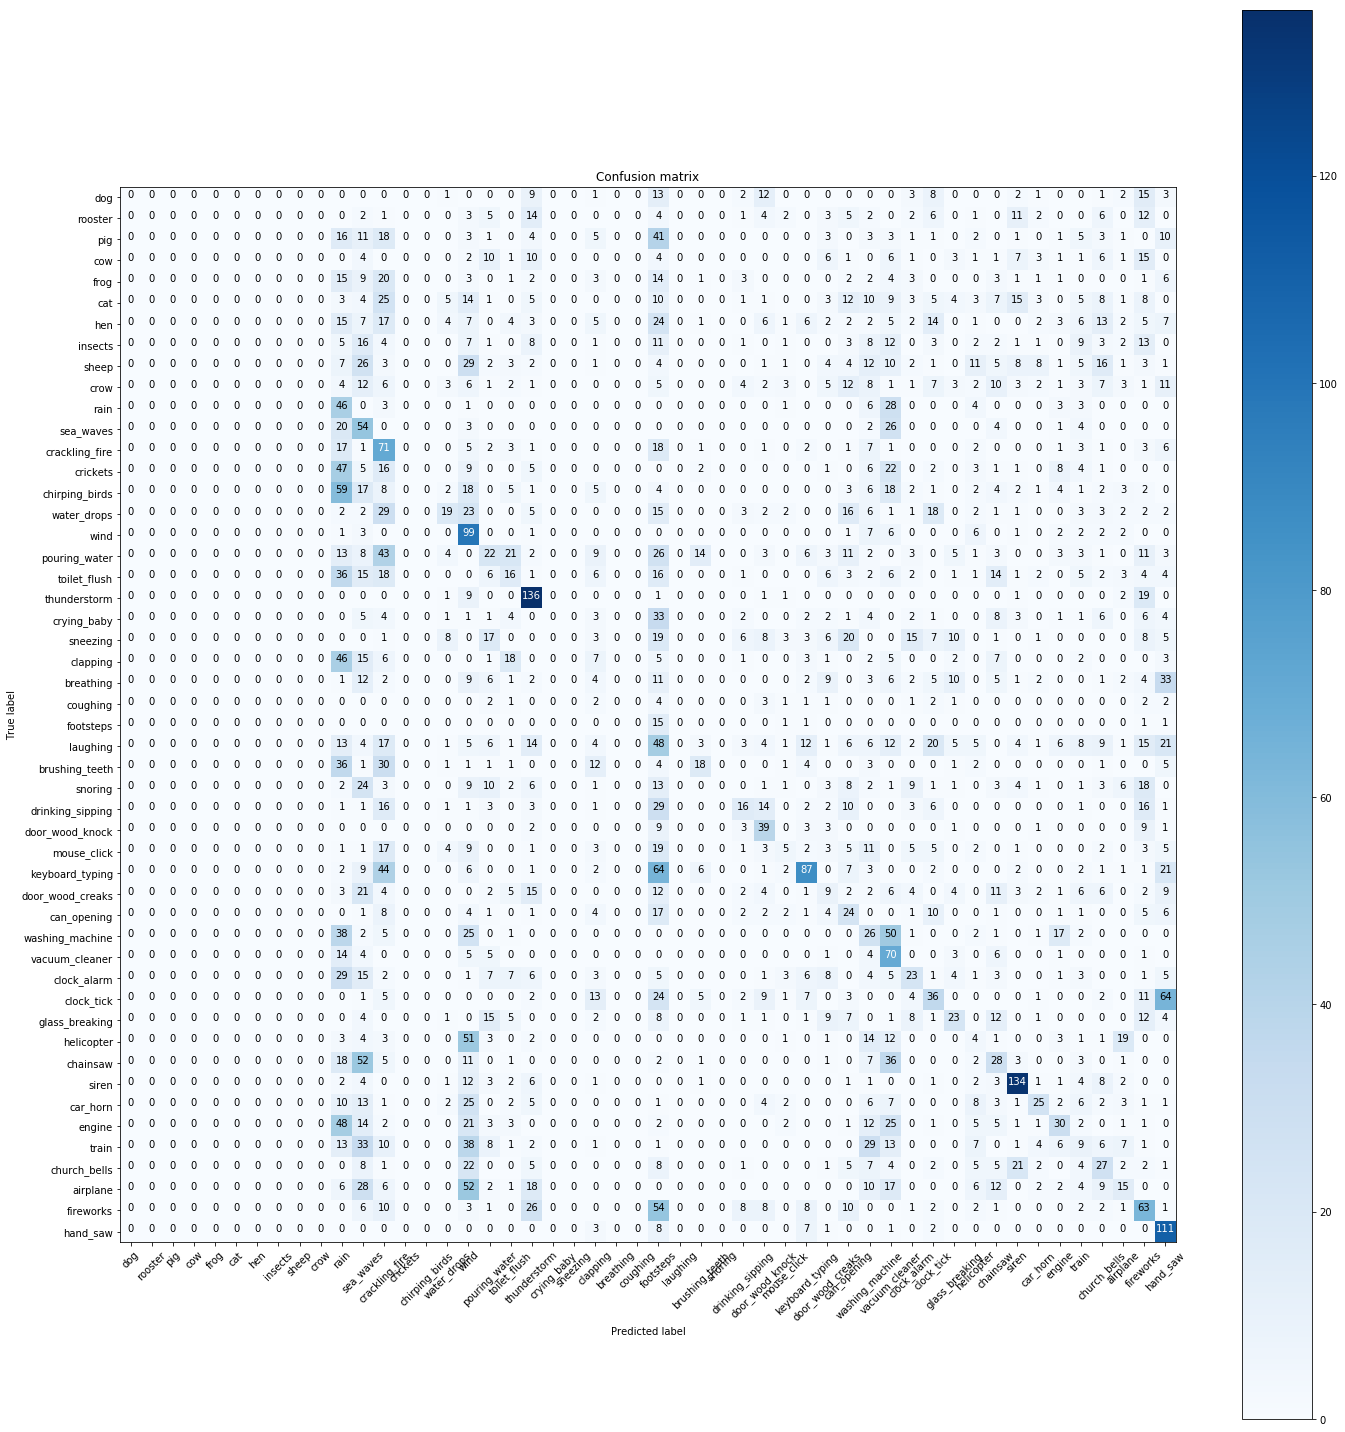

In [13]:
pred = clf.predict(test_X)
print(metrics.accuracy_score(test_y.values[:,1], pred))
cm = metrics.confusion_matrix(test_y.values[:,1], pred)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

## Full Evaluation
We combine the classifiers to determine overall performance

In [14]:
t_df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        blocksize=blocksize, 
                        overlap=overlap,
                        feature_bag=False
                       )
t_df.head()

,target,h_target,metadata
0,0,0,mfcc_2_std mfcc_2_mean mfcc_2_noise mfcc...
1,14,0,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...
2,36,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...
3,36,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...
4,19,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...


In [15]:
predictions = []
full_targets = []
start_time = time.time()
pred_probs = []

test = df[df.fold == 1]

for data_iloc in range(0,len(test)):
    s_time = time.time()
    x_file = test.iloc[data_iloc].metadata.drop(['h_target', 'target', 'fold'], axis=1)

    y_file = test.iloc[data_iloc].target
    
    pred = clf.predict(x_file)
    b = Counter(np.array(pred))
    predictions.append(b.most_common(1)[0][0])
    
    full_targets.append(y_file)
    print("\tFile Time: " + str(time.time() - s_time))

print("\tProcessing Time: " + str(time.time() - start_time))

	File Time: 0.018277645111083984
	File Time: 0.09811568260192871
	File Time: 0.0846714973449707
	File Time: 0.0996866226196289
	File Time: 0.07874131202697754
	File Time: 0.06390976905822754
	File Time: 0.06047248840332031
	File Time: 0.05999755859375
	File Time: 0.05953717231750488
	File Time: 0.059725046157836914
	File Time: 0.0598602294921875
	File Time: 0.011509180068969727
	File Time: 0.06094765663146973
	File Time: 0.060179948806762695
	File Time: 0.06010937690734863
	File Time: 0.06023430824279785
	File Time: 0.058200836181640625
	File Time: 0.05693650245666504
	File Time: 0.050560712814331055
	File Time: 0.050083160400390625
	File Time: 0.05354928970336914
	File Time: 0.09500336647033691
	File Time: 0.07720732688903809
	File Time: 0.06297874450683594
	File Time: 0.05944490432739258
	File Time: 0.059042930603027344
	File Time: 0.060723066329956055
	File Time: 0.08930110931396484
	File Time: 0.06451416015625
	File Time: 0.04283595085144043
	File Time: 0.11303520202636719
	File Ti

	File Time: 0.05882143974304199
	File Time: 0.0631103515625
	File Time: 0.060584068298339844
	File Time: 0.06119346618652344
	File Time: 0.03466010093688965
	File Time: 0.06597352027893066
	File Time: 0.06335687637329102
	File Time: 0.05905294418334961
	File Time: 0.030343055725097656
	File Time: 0.051032066345214844
	File Time: 0.0787820816040039
	File Time: 0.09828472137451172
	File Time: 0.10417675971984863
	File Time: 0.10510587692260742
	File Time: 0.08545565605163574
	File Time: 0.07363629341125488
	File Time: 0.06391215324401855
	File Time: 0.06423330307006836
	File Time: 0.06578969955444336
	File Time: 0.06402873992919922
	File Time: 0.06578874588012695
	File Time: 0.06468963623046875
	File Time: 0.06360197067260742
	File Time: 0.06228041648864746
	File Time: 0.06094551086425781
	File Time: 0.04216933250427246
	File Time: 0.05898475646972656
	File Time: 0.019110918045043945
	File Time: 0.051769256591796875
	File Time: 0.053276777267456055
	File Time: 0.052820682525634766
	File 

0.2425
Confusion matrix, without normalization
[[0 0 0 ... 0 2 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 6 0]
 [0 0 0 ... 0 0 7]]


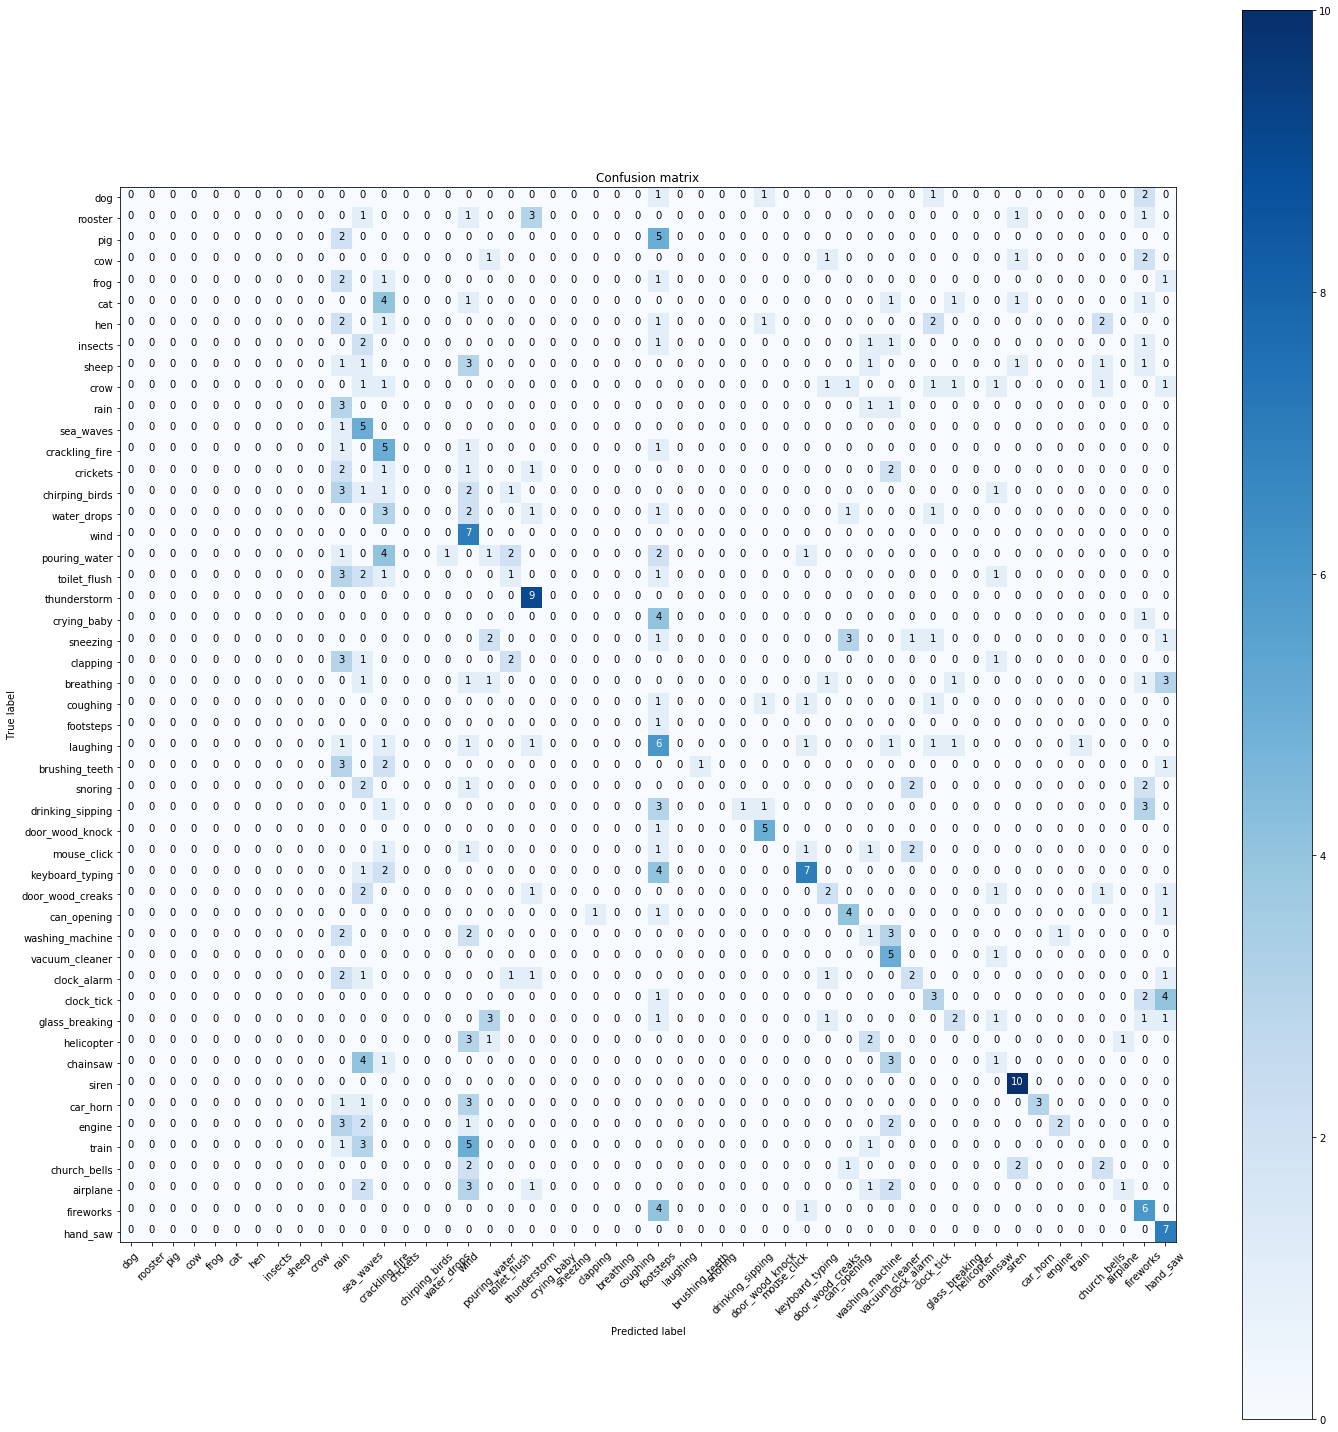

In [16]:
print(metrics.accuracy_score(full_targets, predictions))
cm = metrics.confusion_matrix(full_targets, predictions)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

# Cross Validation

In [17]:
def query_dataset(query_term):
    h_l = mapping[query_term]
    l_l = classes.index(query_term)

    predictions = []

    test = df[df.fold == 1]

    for data_iloc in range(0,len(test)):
        s_time = time.time()
        x_file = test.iloc[data_iloc].metadata.drop(['h_target', 'target', 'fold'], axis=1)

        y_file = test.iloc[data_iloc].target
        predictions.append({
            'file': dataset.iloc[data_iloc].filename,
            'ds_id': data_iloc,
            'prob': np.average(clf.predict_proba(x_file)[:,l_l]),
            'prediction': clf.predict(x_file)
        })
    
    predictions = pd.DataFrame(predictions).sort_values(by=['prob'], ascending=False).reset_index(drop=True)
    
    return predictions

In [18]:
%%time
preds = query_dataset('dog')

TypeError: predict_proba() got an unexpected keyword argument 'verbose'

In [19]:
preds.head()

NameError: name 'preds' is not defined

In [ ]:
# Checking index
def check_accuracy(preds, query, count):
    misclass = []
    
    print(query)
    for data_iloc in range(0, count):
        row = preds.iloc[data_iloc]
        if dataset.iloc[row.ds_id].target != classes.index(query):
            misclass.append(classes[dataset.iloc[row.ds_id].target])
            
    print(misclass)
    print()
    return (count - len(misclass))/count

In [ ]:
# Checking index
check_accuracy(preds, 'dog', 10)

In [ ]:
accuracies = []
for cls in classes:
    preds = query_dataset(cls)
    acc = check_accuracy(preds, cls, 10)
    print(acc)
    accuracies.append(acc)
    
np.average(accuracies)